<div style='color:white;font-size:30px;background-color:#196363;text-align:center;padding-top:20px; padding-bottom:20px;margin-bottom:40px'>VERSIFICATION & AUTHORSHIP ATTRIBUTION</div>
<h1>3.2 Versification-based attribution</h1>
<h2 style='margin-bottom: 50px'>Replication code</h2>

In [1]:
import json
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
import sticho
from collections import defaultdict

<h3>Read data from JSON</h3>

In [2]:
#----------------------------------------------------------------------------------------------------------#
# Files contain a list of poems with following structure:                                                  #   
# [{                                                                                                       #
#    'author': string (name of the author),                                                                #
#    'title': string (title of the poem),                                                                  #
#    'subcorpus': int (id of the subcorpus to which the poem belongs)                                      #
#    'body': [{                                                                                            #
#        'text': string (text of the line)                                                                 #
#        'metre': string (metre of the line)                                                               #
#        'stress_pattern': string (bit string representing stressed/unstressed syllables)                  #
#        'rhyme': list (indices of lines with which this one rhymes)                                       #
#        'words': [{                                                                                       #
#            'token': string,                                                                              #
#            'lemma': string,                                                                              #
#            'tag': string (POS-tag)                                                                       #
#            'xsampa': string (phonetic transcription of word in XSampa)                                   #
#         }, ...]                                                                                          #
#     }, ... ]                                                                                             #
# }, ...]                                                                                                  #
#                                                                                                          #
# CZECH CORPUS                                                                                             #
# Dataset comes from The Corpus of Czech Verse (http://versologie.cz/v2/web_content/corpus.php?lang=en).   #
#                                                                                                          #
# SPANISH CORPUS                                                                                           #
# Dataset comes from Corpus de Sonetos del Siglo de Oro                                                    #
#    (https://github.com/bncolorado/CorpusSonetosSigloDeOro).                                              #
# Tokenization, lemmatization, pos-tagging provided by TreeTagger                                          #
#    (https://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/).                                          #
# Phonetic transcription provided by ESpeak (http://espeak.sourceforge.net/)                               #
#                                                                                                          #
# GERMAN CORPUS                                                                                            #
# Dataset not published here as it comes from proprietary corpus Metricalizer (http://metricalizer.de).    #
#----------------------------------------------------------------------------------------------------------#

data = dict()
with open('data/cs.json', 'r') as f:
    data['cs'] = json.load(f)
with open('data/es.json', 'r') as f:
    data['es'] = json.load(f)
    
# Subcorpora available for each corpus
subcorpora = {'cs': (1,2,3), 'es': (1,2)}

<h3>Number of samples per author</h3>

In [3]:
# Iterate over subcorpora
for lang in sorted(data):
    for subc in subcorpora[lang]:
        # Extract samples and print the number per author
        s = sticho.Sampler(data[lang], n=100, subcorpus=subc, min_rhymes=40)
        print('='*30, '{0}{1}'.format(lang, subc), '='*30)
        for a in sorted(s.samples_):
            print('{0} ({1})'.format(a, len(s.samples_[a])))

============================== cs1 ==============================
Havelka, Matěj (13)
Hněvkovský, Šebestián (11)
Kulda, Beneš Metod (27)
Nejedlý, Vojtěch (17)
Picek, Václav Jaromír (19)
Pohan, Václav Alexander (10)
Tablic, Bohuslav (16)
Vinařický, Karel Alois (15)
Čelakovský, František Ladislav (12)
============================== cs2 ==============================
H. Uden (17)
Kvapil, František (11)
Mokrý, Otokar (15)
Nečas, Jan Evangelista (10)
Sládek, Josef Václav (16)
Vrchlický, Jaroslav (281)
Čech, Svatopluk (13)
============================== cs3 ==============================
Klášterský, Antonín (64)
Kvapil, Jaroslav (19)
Leubner, František (10)
Machar, Josef Svatopluk (21)
Sova, Antonín (15)
============================== es1 ==============================
Fernando de Herrera (40)
Francisco de Borja (17)
Gutierre de Cetina (31)
Hernando de Acunya (10)
Luis de Góngora (14)
============================== es2 ==============================
Argensola Bartolome (19)
Francisco de Quev

<h3>Cross-validation</h3>

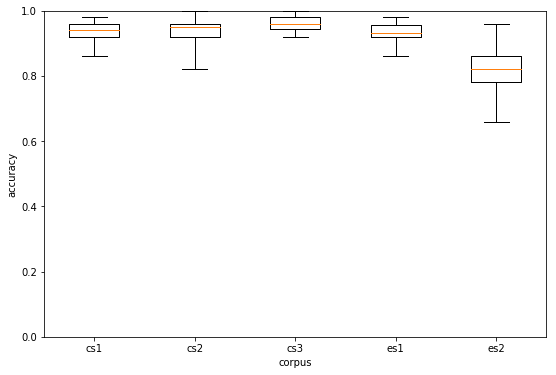

In [4]:
# Container to store accuracy estimations
acc = defaultdict(list)
# Container to store predictions
decisions = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

# Iterate over subcorpora
for lang in sorted(data):
    for subc in subcorpora[lang]:
      
        # Perform 30 iterations
        for iteration in range(30):            

            print('{0}{1} | iteration #{2}   '.format(lang, subc, iteration+1), end='\r')
            
            # SAMPLING
            s = sticho.Sampler(data[lang], n=100, subcorpus=subc, min_rhymes=40)
            # Select 5 authors by random
            s.level_authors(n=5)
            # Randomly select 10 samples by each author
            s.level_samples(max_=10)
                    
            # CLASSIFICATION WITH VERSIFICATION
            f = sticho.Features(s)    
            f.rhythmic_ngrams(n=2, mft=0)
            f.rhythmic_ngrams(n=3, mft=0)
            f.rhythmic_ngrams(n=4, mft=0)
            f.rhyme_profile(method='word_length', mft=0, ending='mf')
            f.rhyme_profile(method='stress', mft=0, ending='mf')
            f.rhyme_profile(method='pos', mft=0, ending='mf')
            f.rhyme_profile(method='sounds', mft=0, ending='mf', snd_position=1)
            f.rhyme_profile(method='sounds', mft=0, ending='mf', snd_position=2)
            f.rhyme_profile(method='sounds', mft=0, ending='f', snd_position=3)
            f.rhyme_profile(method='sounds', mft=0, ending='f', snd_position=4)
            f.sound_frequencies(mft=30)
            f.build_dataframe()    
            # Cross-validation
            c = sticho.Classification(f, clf='svm', kernel='linear', C=1)
            acc[lang+str(subc)].append(c.cross_validation())
            for d in c.results['decisions']:
                decisions[lang+str(subc)][d[0]][c.results['decisions'][d]] += 1
                  
# Plot the chart
print(' '*40)
plotdata = [ acc['cs1'], acc['cs2'], acc['cs3'], acc['es1'], acc['es2'] ]
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.boxplot(plotdata, whis=[0,100])
ax.set_ylim(0,1)
ax.set_xlabel('corpus')
ax.set_ylabel('accuracy')
ax.set_xticklabels(['cs1', 'cs2', 'cs3', 'es1', 'es2']);

<h3>Confusion matrices</h3>

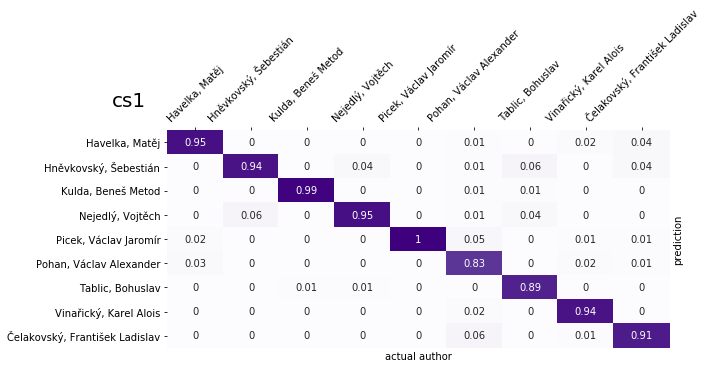

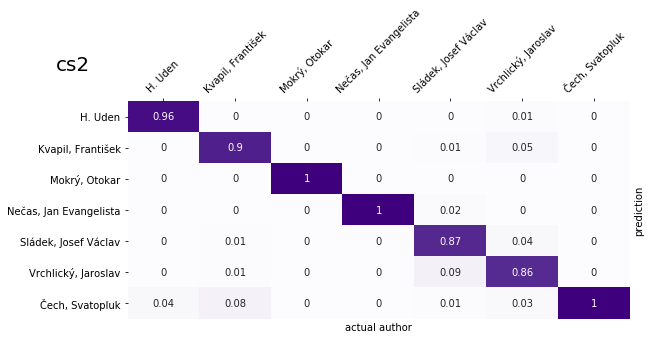

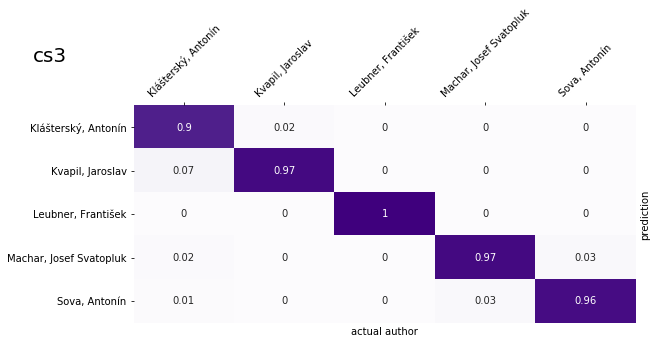

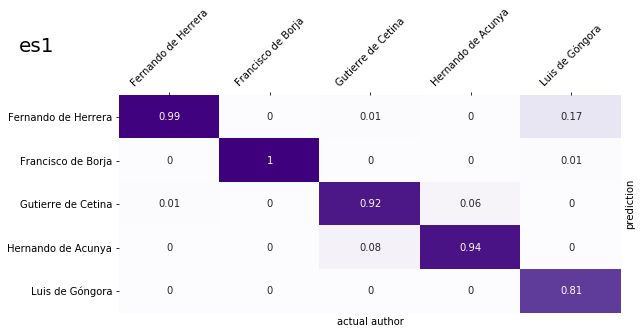

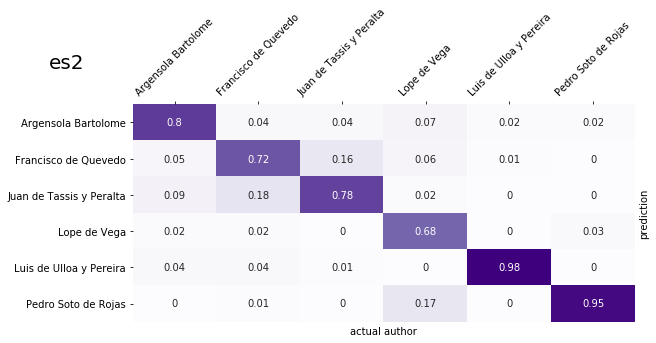

In [7]:
# Iterate over subcorpora
for subcorpus in sorted(decisions):
    # Transform dict with decisions to dataframe
    confusion_matrix = pd.DataFrame.from_dict(decisions[subcorpus]).fillna(0)
    # Divide cells by sum of columns to get relative numbers      
    confusion_matrix = confusion_matrix.div(confusion_matrix.sum(axis=0), axis=1).round(2)
    # Plot the heatmap
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(111)
    ax = sns.heatmap(confusion_matrix, cbar=False, cmap='Purples', annot=True)
    ax.xaxis.tick_top()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.text(-1, -1, subcorpus, fontsize=20);
    ax.set_xlabel('actual author')
    ax.set_ylabel('prediction')
    ax.yaxis.set_label_position("right")

<h2>3.2.1 Feature importance</h2>

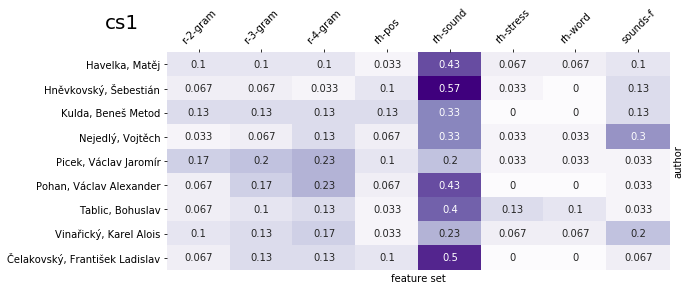

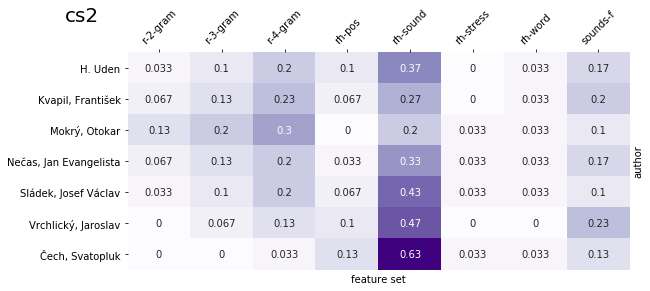

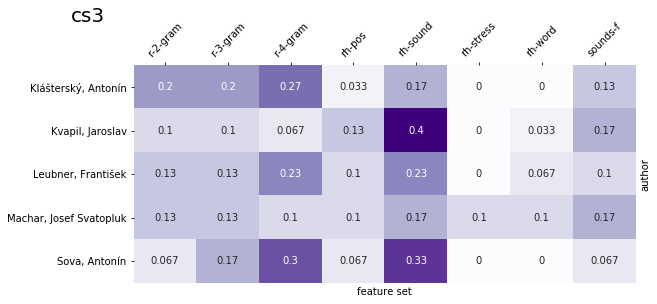

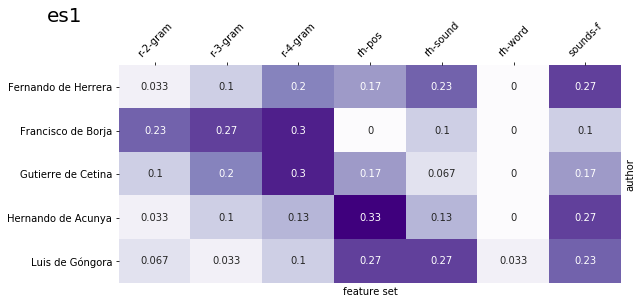

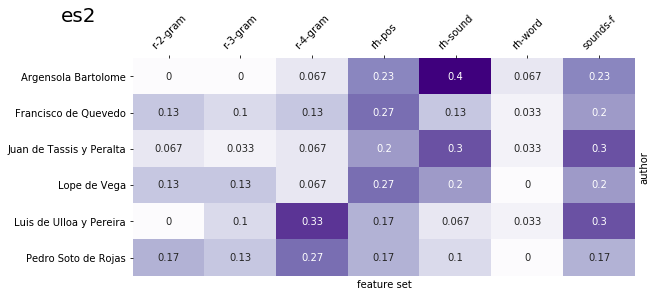

In [3]:
# Iterate over subcorpora
for lang in sorted(data):
    for subc in subcorpora[lang]:
        fi = pd.DataFrame()
        
        # Perform 30 iterations
        for iteration in range(30):            

            print('{0}{1} | iteration #{2}   '.format(lang, subc, iteration+1), end='\r')
            
            # SAMPLING
            s = sticho.Sampler(data[lang], n=100, subcorpus=subc, min_rhymes=40)
            # Select 5 authors by random
            s.level_authors(n=5)
            # Randomly select 10 samples by each author
            s.level_samples(max_=10)
                    
            # CLASSIFICATION WITH VERSIFICATION
            f = sticho.Features(s)    
            f.rhythmic_ngrams(n=2, mft=0)
            f.rhythmic_ngrams(n=3, mft=0)
            f.rhythmic_ngrams(n=4, mft=0)
            f.rhyme_profile(method='word_length', mft=0, ending='mf')
            f.rhyme_profile(method='stress', mft=0, ending='mf')
            f.rhyme_profile(method='pos', mft=0, ending='mf')
            f.rhyme_profile(method='sounds', mft=0, ending='mf', snd_position=1)
            f.rhyme_profile(method='sounds', mft=0, ending='mf', snd_position=2)
            f.rhyme_profile(method='sounds', mft=0, ending='f', snd_position=3)
            f.rhyme_profile(method='sounds', mft=0, ending='f', snd_position=4)
            f.sound_frequencies(mft=30)
            f.build_dataframe()    
            
            # Feature importances
            c = sticho.Classification(f, clf='svm_ovr', kernel='linear', C=1)
            fi = fi.add(np.square(c.feature_importances()), fill_value=0)
        
        
        scores = defaultdict(lambda: defaultdict(int))
        
        for row in fi.iterrows():
            author, fi_data = row
            for feature in fi_data.sort_values(ascending=False).index[:30]:
                if feature.startswith('ngt2'):
                    scores['r-2-gram'][author] += 1
                elif feature.startswith('ngt3'):
                    scores['r-3-gram'][author] += 1
                elif feature.startswith('ngt4'):
                    scores['r-4-gram'][author] += 1
                elif feature.startswith('rhw'):
                    scores['rh-word'][author] += 1
                elif feature.startswith('rhs'):
                    scores['rh-stress'][author] += 1
                elif feature.startswith('rhp'):
                    scores['rh-pos'][author] += 1
                elif feature.startswith('rhx'):
                    scores['rh-sound'][author] += 1
                elif feature.startswith('snd'):
                    scores['sounds-f'][author] += 1                
        
        scores = pd.DataFrame.from_dict(scores).fillna(0)
        scores = scores.div(scores.sum(axis=1), axis=0)
        
        fig = plt.figure(figsize=(9, 4))
        ax = fig.add_subplot(111)
        ax = sns.heatmap(scores, cbar=False, cmap='Purples', annot=True)
        ax.xaxis.tick_top()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.text(-1, -1, lang+str(subc), fontsize=20);        
        ax.set_xlabel('feature set')
        ax.set_ylabel('author')
        ax.yaxis.set_label_position("right")
